We implement a "linear scan" based algorithm for the inference of first-order linear recurrences:
$$
    x_t = a_{t} x_{t-1} + u_t
$$

The algorithm is implemented in C++ and is exposed to Python via torch.ops.


In [1]:
import torch 
import fused_linear_scan

This time the package includes two kernels:
- `fused_linear_scan`: a simple native torch ops kernel
- `fused_linear_scan2`: we used a simple trick to make it faster, 
    i.e. using explicit pointer arithmetic rather than torch indexing.

The optimized kernel is more than one order of magnitude faster while using the same amount of memory.



In [2]:
import time
import matplotlib.pyplot as plt
from statistics import median
from memory_profiler import memory_usage

x = torch.randn(1, 32)
a = torch.randn(1, 32, 128)
u = torch.randn(1, 32, 128)
y = torch.ops.linear_scan.fused_linear_scan(x, a, u)
y2 = torch.ops.linear_scan.fused_linear_scan2(x, a, u)

In [3]:
def native_linear_scan(x0, a, u):
    B, C, N = a.shape
    x = torch.zeros(B, C, N, dtype=a.dtype, device=a.device)
    x[..., 0] = a[..., 0] * x0 + u[..., 0]
    for t in range(1, N):
        x[..., t] = a[..., t] * x[..., t-1] + u[..., t]
    return x

y_native = native_linear_scan(x, a, u)

# Check if the two implementations give the same result
assert torch.allclose(y, y_native, atol=1e-5)
assert torch.allclose(y2, y_native, atol=1e-5)
print("Both implementations give the same result!")


Both implementations give the same result!


In [4]:
def measure_peak_memory(func, *args, **kwargs):
    #baseline = min(memory_usage(-1, interval=0.001, timeout=1))
    mem_usage = memory_usage((func, args, kwargs), interval=0.001, timeout=None)
    return max(mem_usage)# - baseline

# Define a range of sequence lengths to test
sequence_lengths = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]
channels = 2048
iters = 20  # Number of iterations for median timing and memory profiling

methods = {
    "native_linear_scan": native_linear_scan,
    "fused_linear_scan": torch.ops.linear_scan.fused_linear_scan,
    "fused_linear_scan2": torch.ops.linear_scan.fused_linear_scan2,
}
stats = {name: {"times": [], "peak_memory": []} for name in methods}

for L in sequence_lengths:
    # Create random inputs of length L for each channel
    x0 = torch.randn(1, channels)
    a = torch.randn(1, channels, L)
    u = torch.randn(1, channels, L)

    # Warm-up runs for each method for reliable measurements
    for name, func in methods.items():
        _ = func(x0, a, u)
    
    # Measure timing and peak memory for each method
    for name, func in methods.items():
        run_times = []
        mem_peaks = []
        for _ in range(iters):
            start = time.perf_counter()
            _ = func(x0, a, u)
            run_times.append((time.perf_counter() - start) * 1000)
        # for _ in range(iters):
        peak_mem = measure_peak_memory(func, x0, a, u)
        mem_peaks.append(peak_mem)
        stats[name]["times"].append(median(run_times))
        stats[name]["peak_memory"].append(median(mem_peaks))
    
    # Print the results for the current sequence length
    times_str = ", ".join(f"{name}: {stats[name]['times'][-1]:.2f} ms" for name in methods)
    mem_str = ", ".join(f"{name}: {stats[name]['peak_memory'][-1]:.2f} MB" for name in methods)
    print(f"L={L}, {times_str}, {mem_str}")

L=2, native_linear_scan: 0.03 ms, fused_linear_scan: 0.01 ms, fused_linear_scan2: 0.00 ms, native_linear_scan: 231.59 MB, fused_linear_scan: 231.62 MB, fused_linear_scan2: 231.70 MB
L=4, native_linear_scan: 0.03 ms, fused_linear_scan: 0.02 ms, fused_linear_scan2: 0.00 ms, native_linear_scan: 231.94 MB, fused_linear_scan: 231.98 MB, fused_linear_scan2: 232.02 MB
L=8, native_linear_scan: 0.06 ms, fused_linear_scan: 0.05 ms, fused_linear_scan2: 0.01 ms, native_linear_scan: 232.22 MB, fused_linear_scan: 232.28 MB, fused_linear_scan2: 232.30 MB
L=16, native_linear_scan: 0.16 ms, fused_linear_scan: 0.12 ms, fused_linear_scan2: 0.01 ms, native_linear_scan: 232.72 MB, fused_linear_scan: 232.84 MB, fused_linear_scan2: 233.00 MB
L=32, native_linear_scan: 0.33 ms, fused_linear_scan: 0.27 ms, fused_linear_scan2: 0.03 ms, native_linear_scan: 235.05 MB, fused_linear_scan: 235.30 MB, fused_linear_scan2: 236.05 MB
L=64, native_linear_scan: 0.69 ms, fused_linear_scan: 0.57 ms, fused_linear_scan2: 0.08 

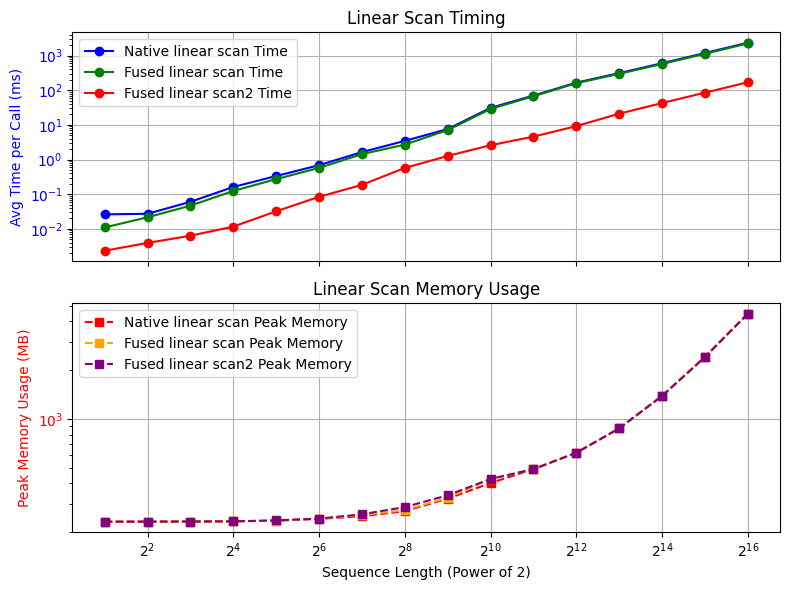

In [5]:
fig, (ax_time, ax_mem) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot timing results in the first subplot
ax_time.set_xscale('log', base=2)
ax_time.set_yscale('log')
lns1 = ax_time.plot(sequence_lengths, stats['native_linear_scan']['times'], '-o', label='Native linear scan Time', color='blue')
lns2 = ax_time.plot(sequence_lengths, stats['fused_linear_scan']['times'], '-o', label='Fused linear scan Time', color='green')
lns3 = ax_time.plot(sequence_lengths, stats['fused_linear_scan2']['times'], '-o', label='Fused linear scan2 Time', color='red')
ax_time.set_ylabel('Avg Time per Call (ms)', color='blue')
ax_time.tick_params(axis='y', labelcolor='blue')
ax_time.grid(True)
ax_time.legend(loc='upper left')
ax_time.set_title('Linear Scan Timing')

# Plot peak memory usage in the second subplot
ax_mem.set_xscale('log', base=2)
ax_mem.set_yscale('log')
lns3 = ax_mem.plot(sequence_lengths, stats['native_linear_scan']['peak_memory'], '--s', label='Native linear scan Peak Memory', color='red')
lns4 = ax_mem.plot(sequence_lengths, stats['fused_linear_scan']['peak_memory'], '--s', label='Fused linear scan Peak Memory', color='orange')
lns5 = ax_mem.plot(sequence_lengths, stats['fused_linear_scan2']['peak_memory'], '--s', label='Fused linear scan2 Peak Memory', color='purple')
ax_mem.set_xlabel('Sequence Length (Power of 2)')
ax_mem.set_ylabel('Peak Memory Usage (MB)', color='red')
ax_mem.tick_params(axis='y', labelcolor='red')
ax_mem.grid(True)
ax_mem.legend(loc='upper left')
ax_mem.set_title('Linear Scan Memory Usage')

plt.tight_layout()
plt.show()

In [6]:
import torch.nn as nn

class LinearRecurrence(nn.Module):
    def __init__(self, channels: int):
        """
        channels: Number of input/output channels.
        seq_len: (Optional) Expected sequence length (not strictly required for the model definition).
        """
        super().__init__()
        self.au_projection = nn.Linear(channels, 2*channels)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.transpose(1, 2)       # (N, L, C)
        au = self.au_projection(x)  # (N, L, 2C)
        au = au.transpose(1, 2)     # (N, 2C, L)
        a, u = au.chunk(2, dim=-1)  # (N, C, L), (N, C, L)
        x = torch.ops.linear_scan.fused_linear_scan(torch.zeros_like(a[..., 0]), a, u)
        return x

In [7]:
from torch.export import export, ExportedProgram
from executorch.backends.xnnpack.partition.xnnpack_partitioner import XnnpackPartitioner
from executorch.exir import EdgeProgramManager, to_edge_transform_and_lower

SEQ_LEN = 32
CHANNELS = 4
model = LinearRecurrence(channels=CHANNELS)
example_input = torch.randn(1, CHANNELS, SEQ_LEN)

exported_program: ExportedProgram = export(model, (example_input,))
edge_program: EdgeProgramManager = to_edge_transform_and_lower(exported_program, partitioner=[XnnpackPartitioner()])
print(edge_program.exported_program().graph_module)


GraphModule(
  (lowered_module_0): LoweredBackendModule()
)



def forward(self, x):
    lowered_module_0 = self.lowered_module_0
    executorch_call_delegate = torch.ops.higher_order.executorch_call_delegate(lowered_module_0, x);  lowered_module_0 = x = None
    getitem_2 = executorch_call_delegate[0];  executorch_call_delegate = None
    aten_split_with_sizes_copy_default = executorch_exir_dialects_edge__ops_aten_split_with_sizes_copy_default(getitem_2, [16, 16], -1);  getitem_2 = None
    getitem = aten_split_with_sizes_copy_default[0]
    getitem_1 = aten_split_with_sizes_copy_default[1];  aten_split_with_sizes_copy_default = None
    aten_select_copy_int = executorch_exir_dialects_edge__ops_aten_select_copy_int(getitem, 2, 0)
    aten_full_like_default = executorch_exir_dialects_edge__ops_aten_full_like_default(aten_select_copy_int, 0, pin_memory = False, memory_format = torch.preserve_format);  aten_select_copy_int = None
    linear_scan_fused_linear_scan_default = executorch_exi

In [8]:
from executorch.devtools.backend_debug import get_delegation_info
from tabulate import tabulate
graph_module = edge_program.exported_program().graph_module
delegation_info = get_delegation_info(graph_module)
print(delegation_info.get_summary())
df = delegation_info.get_operator_delegation_dataframe()
print(tabulate(df, headers="keys", tablefmt="fancy_grid"))

Total delegated subgraphs: 1
Number of delegated nodes: 3
Number of non-delegated nodes: 7

╒════╤═══════════════════════════════════════╤═══════════════════════════════════╤═══════════════════════════════════════╕
│    │ op_type                               │   occurrences_in_delegated_graphs │   occurrences_in_non_delegated_graphs │
╞════╪═══════════════════════════════════════╪═══════════════════════════════════╪═══════════════════════════════════════╡
│  0 │ aten_full_like_default                │                                 0 │                                     1 │
├────┼───────────────────────────────────────┼───────────────────────────────────┼───────────────────────────────────────┤
│  1 │ aten_linear_default                   │                                 1 │                                     0 │
├────┼───────────────────────────────────────┼───────────────────────────────────┼───────────────────────────────────────┤
│  2 │ aten_permute_copy_default             │ 

The reason why a custom kernel is necessary for the linear scan used is that exporting recursive operations leads to a large number of nodes in the graph.

In [9]:

class NativeLinearRecurrence(nn.Module):
    def __init__(self, channels: int):
        """
        channels: Number of input/output channels.
        seq_len: (Optional) Expected sequence length (not strictly required for the model definition).
        """
        super().__init__()
        self.au_projection = nn.Linear(channels, 2*channels)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.transpose(1, 2)       # (N, L, C)
        au = self.au_projection(x)  # (N, L, 2C)
        au = au.transpose(1, 2)     # (N, 2C, L)
        a, u = au.chunk(2, dim=-1)  # (N, C, L), (N, C, L)
        x = native_linear_scan(torch.zeros_like(a[..., 0]), a, u)
        return x

SEQ_LEN = 32
CHANNELS = 4
model = NativeLinearRecurrence(channels=CHANNELS)
example_input = torch.randn(1, CHANNELS, SEQ_LEN)

exported_program: ExportedProgram = export(model, (example_input,))
edge_program: EdgeProgramManager = to_edge_transform_and_lower(exported_program, partitioner=[XnnpackPartitioner()])
print(edge_program.exported_program().graph_module)

graph_module = edge_program.exported_program().graph_module
delegation_info = get_delegation_info(graph_module)
print(delegation_info.get_summary())
df = delegation_info.get_operator_delegation_dataframe()
print(tabulate(df, headers="keys", tablefmt="fancy_grid"))


GraphModule(
  (lowered_module_0): LoweredBackendModule()
  (lowered_module_1): LoweredBackendModule()
  (lowered_module_2): LoweredBackendModule()
  (lowered_module_3): LoweredBackendModule()
  (lowered_module_4): LoweredBackendModule()
  (lowered_module_5): LoweredBackendModule()
  (lowered_module_6): LoweredBackendModule()
  (lowered_module_7): LoweredBackendModule()
  (lowered_module_8): LoweredBackendModule()
  (lowered_module_9): LoweredBackendModule()
  (lowered_module_10): LoweredBackendModule()
  (lowered_module_11): LoweredBackendModule()
  (lowered_module_12): LoweredBackendModule()
  (lowered_module_13): LoweredBackendModule()
  (lowered_module_14): LoweredBackendModule()
  (lowered_module_15): LoweredBackendModule()
  (lowered_module_16): LoweredBackendModule()
)



def forward(self, x):
    aten_full_default = executorch_exir_dialects_edge__ops_aten_full_default([1, 8, 16], 0, dtype = torch.float32, layout = torch.strided, device = device(type='cpu'), pin_memory = False)


Alternative algorithms to the linear scan for the inferencce of linear recurrences are, e.g different *parallel* scan algorithms, where the parallelism is in the *time* dimension.
See, e.g
- [Blelloch's parallel scan](https://www.cs.cmu.edu/~guyb/papers/Ble93.pdf) (Sec 1.4.1)
- [Parallel Prefix Sum/Scan in CUDA](https://developer.nvidia.com/gpugems/gpugems3/part-vi-gpu-computing/chapter-39-parallel-prefix-sum-scan-cuda)
- [Notes on scan implementations](https://ams148-spring18-01.courses.soe.ucsc.edu/system/files/attachments/note5.pdf) (Noteworthy: Sec 2.3 discusses a chunked scan implementation that can also be use to control the peak memory usage)



